In [ ]:
#Cell 1: Mount Google Drive and Install Libraries

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install necessary libraries
!pip install tensorflow pandas numpy scikit-learn matplotlib

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell 2: Data Loading Function (Final Version for @DATA Format)

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import io # Required for in-memory file handling

# --- Configuration ---
DRIVE_PROJECT_PATH = '/content/drive/My Drive/Colab Notebooks/TinyML_Fall_Detection/'
DATASET_PATH = os.path.join(DRIVE_PROJECT_PATH, 'MobiFall_Dataset_v2.0/')

# Specific activity folder names that are considered falls
FALL_TYPES = ['FOL', 'FKL', 'BSC', 'SDL']

# Windowing and Feature parameters
TIME_STEPS = 150
STEP = 75
NUM_FEATURES = 3 # We are only using the x, y, z from accelerometer

def load_data_final_working():
    """
    Final robust version. This function correctly handles the file format by
    finding the @DATA marker and only parsing the comma-separated data that follows.
    """
    segments = []
    labels = []

    print("--- Starting Final Data Loading Attempt (with @DATA parser) ---")

    if not os.path.exists(DATASET_PATH):
        print(f"[ERROR] The base dataset path does not exist: {DATASET_PATH}")
        return np.array([]), np.array([])

    subject_folders = sorted([d for d in os.listdir(DATASET_PATH) if d.startswith('sub') and os.path.isdir(os.path.join(DATASET_PATH, d))])

    for subject_folder in subject_folders:
        subject_path = os.path.join(DATASET_PATH, subject_folder)

        for activity_group_folder in os.listdir(subject_path):
            activity_group_path = os.path.join(subject_path, activity_group_folder)
            if not os.path.isdir(activity_group_path): continue

            for specific_activity in os.listdir(activity_group_path):
                specific_activity_path = os.path.join(activity_group_path, specific_activity)
                if not os.path.isdir(specific_activity_path): continue

                is_fall = 1 if specific_activity in FALL_TYPES else 0

                all_files_in_dir = os.listdir(specific_activity_path)
                acc_files = sorted([f for f in all_files_in_dir if '_acc_' in f.lower() and f.lower().endswith('.txt')])

                if not acc_files:
                    continue

                for acc_filename in acc_files:
                    file_path = os.path.join(specific_activity_path, acc_filename)
                    try:
                        with open(file_path, 'r') as f:
                            data_lines = []
                            data_started = False
                            for line in f:
                                stripped_line = line.strip()
                                if not stripped_line: continue # Skip any blank lines

                                # Once we find @DATA, we start appending subsequent lines
                                if data_started:
                                    data_lines.append(stripped_line)

                                # Check for the @DATA marker (case-insensitive)
                                if stripped_line.upper() == '@DATA':
                                    data_started = True

                        if not data_lines:
                            print(f"[Warning] Skipped file with no data found after @DATA marker: {file_path}")
                            continue

                        # Create an in-memory text buffer from our collected data lines
                        data_buffer = io.StringIO('\n'.join(data_lines))

                        # Now, read this clean buffer with pandas. It should only contain data.
                        # The first column is timestamp, the next three are acc_x, acc_y, acc_z
                        df = pd.read_csv(data_buffer, header=None, sep=',')

                        # We need columns 1, 2, and 3 (the x,y,z data)
                        if df.shape[1] >= 4:
                            # Select columns 1, 2, 3 for accelerometer data
                            data_for_windowing = df.iloc[:, 1:4].values.astype(float)

                            for i in range(0, len(data_for_windowing) - TIME_STEPS + 1, STEP):
                                window = data_for_windowing[i: i + TIME_STEPS]
                                segments.append(window)
                                labels.append(is_fall)
                        else:
                            print(f"[Warning] Skipped file with insufficient columns after parsing data ({df.shape}): {file_path}")

                    except Exception as e:
                        print(f"[ERROR] Could not process file {file_path}. Error: {e}")

    if not segments:
        print("\n[CRITICAL ERROR] No data was loaded. Please check the warnings above.")
        return np.array([]), np.array([])

    print(f"\n[SUCCESS] Successfully loaded {len(segments)} windows using accelerometer data.")
    return np.array(segments), np.array(labels)

print("Final working data loading function defined.")

Final working data loading function defined.


In [ ]:
# Cell 3: Data Processing and Saving (Corrected)

# 1. Load and process the data from Google Drive using the FINAL corrected function
# --- CORRECTED LINE: Changed function name to match the one defined in Cell 2 ---
X, y = load_data_final_working()

if X.size == 0:
    print("\nHalting execution because no data was loaded. Please review the output above for errors in file paths or structure.")
else:
    print(f"\nShape of X before split: {X.shape}")
    print(f"Shape of y before split: {y.shape}")

    unique_labels, counts = np.unique(y, return_counts=True)
    print(f"Label distribution: {dict(zip(unique_labels, counts))} (0=ADL, 1=Fall)")

    # 2. Split the data into training and testing sets
    if X.shape[0] > 1 and len(unique_labels) > 1:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    else:
        # This condition is kept for safety, but with the corrected loader, it should not be triggered.
        raise ValueError("Insufficient data to proceed with model training. Check data loading logs.")

    # 3. Standardize the data
    scaler = StandardScaler()
    # Reshape to 2D for the scaler, fit it, and then reshape back to 3D
    X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
    scaler.fit(X_train_reshaped)

    X_train_scaled = scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

    print("\n--- Scaler Info (COPY THESE for embedded device) ---")
    scaler_mean_list = scaler.mean_.tolist()
    scaler_scale_list = scaler.scale_.tolist()
    print(f"float SCALER_MEAN[] = {{{', '.join(map(str, scaler_mean_list))}}};")
    print(f"float SCALER_SCALE[] = {{{', '.join(map(str, scaler_scale_list))}}};")
    print("--------------------------------------------------\n")

    # 4. Save the processed data to Google Drive
    print("Saving processed data to Google Drive...")
    np.save(os.path.join(DRIVE_PROJECT_PATH, 'X_train.npy'), X_train_scaled)
    np.save(os.path.join(DRIVE_PROJECT_PATH, 'X_test.npy'), X_test_scaled)
    np.save(os.path.join(DRIVE_PROJECT_PATH, 'y_train.npy'), y_train)
    np.save(os.path.join(DRIVE_PROJECT_PATH, 'y_test.npy'), y_test)

    print("Data preparation complete and files saved to Google Drive.")

--- Starting Final Data Loading Attempt (with @DATA parser) ---

[SUCCESS] Successfully loaded 12971 windows using accelerometer data.

Shape of X before split: (12971, 150, 3)
Shape of y before split: (12971,)
Label distribution: {np.int64(0): np.int64(10193), np.int64(1): np.int64(2778)} (0=ADL, 1=Fall)

--- Scaler Info (COPY THESE for embedded device) ---
float SCALER_MEAN[] = {-0.22145857198715083, 7.362072807828835, 1.299067169081437};
float SCALER_SCALE[] = {4.034813242379331, 5.193313431588992, 4.143631195725836};
--------------------------------------------------

Saving processed data to Google Drive...
Data preparation complete and files saved to Google Drive.


Loading preprocessed data from Google Drive...
Data loaded successfully.
Training data shape: (10376, 150, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 146, 8)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 146, 8)         │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 73, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 73, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 69, 16)         │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 69, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 34, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 34, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        17,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,386 (71.82 KB)

 Trainable params: 18,338 (71.63 KB)

 Non-trainable params: 48 (192.00 B)


Training the model...
Epoch 1/25
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8427 - loss: 0.4924 - val_accuracy: 0.8844 - val_loss: 0.2908
Epoch 2/25
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9343 - loss: 0.1677 - val_accuracy: 0.9277 - val_loss: 0.1722
Epoch 3/25
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9447 - loss: 0.1464 - val_accuracy: 0.9340 - val_loss: 0.1590
Epoch 4/25
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9502 - loss: 0.1264 - val_accuracy: 0.9340 - val_loss: 0.1685
Epoch 5/25
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9471 - loss: 0.1272 - val_accuracy: 0.9345 - val_loss: 0.1696
Epoch 6/25
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9488 - loss: 0.1242 - val_accuracy: 0.9408 - val_loss: 0.1498
Epoch 7/25
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9534 - loss: 0.1212 - val_accuracy: 0.9427 - val_loss: 0.1533
Epoch 8/25
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9563 - 

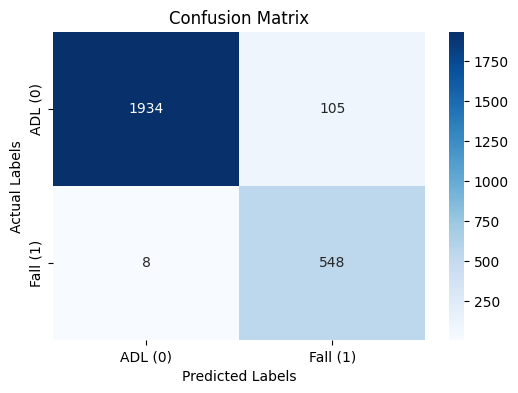


Saving the trained model to Google Drive...
Model saved as /content/drive/My Drive/Colab Notebooks/TinyML_Fall_Detection/fall_detection_model.h5


In [ ]:
#Cell 4: Model Training

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration (UPDATED FOR COLAB/DRIVE) ---
DRIVE_PROJECT_PATH = '/content/drive/My Drive/Colab Notebooks/TinyML_Fall_Detection/'

# --- Load Preprocessed Data from Google Drive ---
print("Loading preprocessed data from Google Drive...")
try:
    X_train = np.load(os.path.join(DRIVE_PROJECT_PATH, 'X_train.npy'))
    y_train = np.load(os.path.join(DRIVE_PROJECT_PATH, 'y_train.npy'))
    X_test = np.load(os.path.join(DRIVE_PROJECT_PATH, 'X_test.npy'))
    y_test = np.load(os.path.join(DRIVE_PROJECT_PATH, 'y_test.npy'))
    print("Data loaded successfully.")
except FileNotFoundError:
    print("ERROR: Processed data files not found in Google Drive. Please run the previous cell (Data Preparation) first.")
    # Stop further execution in this cell if files are missing
    raise

print(f"Training data shape: {X_train.shape}")

# --- Model Configuration ---
TIME_STEPS = X_train.shape[1]
NUM_FEATURES = X_train.shape[2]
NUM_CLASSES = len(np.unique(y_train)) # Dynamically get number of classes

if NUM_CLASSES < 2:
    print("Error: Not enough classes in the training data. Need at least 2.")
    raise ValueError("Insufficient classes for training.")


# --- Build the CNN Model ---
# Architecture is slightly adjusted for robustness and to be suitable for TinyML
model = Sequential([
    Conv1D(filters=8, kernel_size=5, activation='relu', input_shape=(TIME_STEPS, NUM_FEATURES)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),

    Conv1D(filters=16, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),

    Flatten(),

    Dense(32, activation='relu'),
    Dropout(0.5),

    Dense(NUM_CLASSES, activation='softmax')
])

# --- Compile the Model ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --- Train the Model ---
print("\nTraining the model...")
# Adding a callback for early stopping can be beneficial
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    batch_size=64, # Adjusted batch size
    epochs=25,     # Increased epochs slightly, early stopping will manage
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# --- Evaluate the Model ---
print("\nEvaluating the model on test data...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
target_names = ['ADL (0)', 'Fall (1)'] # Assuming 0 for ADL, 1 for Fall
print(classification_report(y_test, y_pred, target_names=target_names))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


# --- Save the Trained Model to Google Drive ---
print("\nSaving the trained model to Google Drive...")
model_save_path = os.path.join(DRIVE_PROJECT_PATH, 'fall_detection_model.h5')
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

In [ ]:
# Cell 5: Model Conversion to TensorFlow Lite and C Array (FINAL CORRECTED VERSION)

import tensorflow as tf
import numpy as np
import os

# --- Configuration ---
DRIVE_PROJECT_PATH = '/content/drive/My Drive/Colab Notebooks/TinyML_Fall_Detection/'
KERAS_MODEL_PATH = os.path.join(DRIVE_PROJECT_PATH, 'fall_detection_model.h5')
TFLITE_MODEL_PATH = os.path.join(DRIVE_PROJECT_PATH, 'fall_detection_model.tflite')
C_MODEL_PATH = os.path.join(DRIVE_PROJECT_PATH, 'fall_detection_model.h')

# --- Load the saved Keras model ---
# We use compile=False as we only need the architecture and weights for conversion.
model = tf.keras.models.load_model(KERAS_MODEL_PATH, compile=False)


# --- TensorFlow Lite Conversion with Post-Training Integer Quantization ---

# 1. Representative Dataset Generator
X_train_for_rep_data = np.load(os.path.join(DRIVE_PROJECT_PATH, 'X_train.npy'))

def representative_data_gen():
  num_calibration_samples = min(100, X_train_for_rep_data.shape[0])
  for i in range(num_calibration_samples):
    yield [X_train_for_rep_data[i:i+1].astype(np.float32)]

# 2. Initialize and run the TFLite Converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_model_quant = converter.convert()

# 3. Save the quantized TFLite model
with open(TFLITE_MODEL_PATH, 'wb') as f:
    f.write(tflite_model_quant)
print(f"Quantized TFLite model saved to: {TFLITE_MODEL_PATH}")
print(f"TFLite model size: {os.path.getsize(TFLITE_MODEL_PATH)/1024:.2f} KB")


# --- Convert to C byte array using xxd (with a fixed, valid variable name) ---
# THIS IS THE CRITICAL FIX
# We are forcing the C variable name to be 'fall_detection_model_tflite'
# The 'sed' command now replaces the auto-generated name with our desired name.

# Escape spaces in paths for the shell command
escaped_tflite_path = TFLITE_MODEL_PATH.replace(' ', '\\ ')
escaped_c_model_path = C_MODEL_PATH.replace(' ', '\\ ')

# Generate the C header file
os.system(f'xxd -i {escaped_tflite_path} > {escaped_c_model_path}')
# Replace the auto-generated variable name and length with our clean versions
os.system(f"sed -i 's/unsigned char.*/unsigned char fall_detection_model_tflite[] = {{/g' {escaped_c_model_path}")
os.system(f"sed -i 's/unsigned int.*/const unsigned int fall_detection_model_tflite_len = {os.path.getsize(TFLITE_MODEL_PATH)};/g' {escaped_c_model_path}")


print(f"\nTFLite model converted to C source file: {C_MODEL_PATH}")
print(f"C header file size: {os.path.getsize(C_MODEL_PATH)/1024:.2f} KB")
print("\nFirst few lines of the C header file:")
!head -n 5 {C_MODEL_PATH}

Saved artifact at '/tmp/tmp175e1zej'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  140220417954000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140220417958032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140220417960144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140220417961488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140220417961296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140220417959184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140220417963024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140220417964752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140220417963216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140220417965712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140220417962832: Ten

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized TFLite model saved to: /content/drive/My Drive/Colab Notebooks/TinyML_Fall_Detection/fall_detection_model.tflite
TFLite model size: 27.39 KB

TFLite model converted to C source file: /content/drive/My Drive/Colab Notebooks/TinyML_Fall_Detection/fall_detection_model.h
C header file size: 169.02 KB

First few lines of the C header file:
head: cannot open '/content/drive/My' for reading: No such file or directory
head: cannot open 'Drive/Colab' for reading: No such file or directory
head: cannot open 'Notebooks/TinyML_Fall_Detection/fall_detection_model.h' for reading: No such file or directory
